<!-- ---
title: "Week 6"
title-block-banner: true
title-block-style: default
execute:
  freeze: true
  cache: true
format: html
# format: pdf
--- -->

In [1]:
dir <- "~/work/courses/stat380/weeks/week-12/"
# renv::activate(dir)


#### Packages we will require this week

In [3]:
packages <- c(
    # Old packages
    "ISLR2",
    "dplyr",
    "tidyr",
    "readr",
    "purrr",
    "repr",
    "tidyverse",
    "kableExtra",
    "IRdisplay",
    # NEW
    "torch",
    "torchvision",
    "luz"
)

# renv::install(packages)
sapply(packages, require, character.only=TRUE)

ISLR2       dplyr       tidyr       readr       purrr        repr 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
  tidyverse  kableExtra   IRdisplay       torch torchvision         luz 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE

---

# Tue, Apr 12

### Agenda:

1. Real-world neural network classification
1. Dataloaders
1. Torch for image classification

<br><br><br>

## Titanic

In [4]:
url <- "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"

df <- read_csv(url) %>%
    mutate_if(\(x) is.character(x), as.factor) %>%
    mutate(y = Survived) %>%
    select(-c(Name, Survived)) %>%
    (\(x) {
        names(x) <- tolower(names(x))
        x
    })

df %>% head

Rows: 887 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Name, Sex
dbl (6): Survived, Pclass, Age, Siblings/Spouses Aboard, Parents/Children Ab...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


pclass,sex,age,siblings/spouses aboard,parents/children aboard,fare,y
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,male,22,1,0,7.2500,0
1,female,38,1,0,71.2833,1
3,female,26,0,0,7.9250,1
1,female,35,1,0,53.1000,1
3,male,35,0,0,8.0500,0
3,male,27,0,0,8.4583,0


## Breast Cancer Prediction

In [5]:
# url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

# col_names <- c("id", "diagnosis", paste0("feat", 1:30))

# df <- read_csv(
#         url, col_names, col_types = cols()
#     ) %>% 
#     select(-id) %>% 
#     mutate(y = ifelse(diagnosis == "M", 1, 0)) %>%
#     select(-diagnosis)


# df %>% head

### Train/Test Split

In [6]:
k <- 5

test_ind <- sample(
    1:nrow(df), 
    floor(nrow(df) / k),
    replace=FALSE
)

In [7]:
df_train <- df[-test_ind, ]
df_test  <- df[test_ind, ]

nrow(df_train) + nrow(df_test) == nrow(df)

[1] TRUE

### Benchmark with Logistic Regression

In [8]:
fit_glm <- glm(
    y ~ ., 
    df_train %>% mutate_at("y", factor), 
    family = binomial()
)

glm_test <- predict(
    fit_glm, 
    df_test,
    output = "response"
)

glm_preds <- ifelse(glm_test > 0.5, 1, 0)
table(glm_preds, df_test$y)

         
glm_preds   0   1
        0 103  24
        1  14  36

### Neural Net Model

In [9]:
NNet <- nn_module(
  initialize = function(p, q1, q2, q3) {  
    self$hidden1 <- nn_linear(p, q1)
    self$hidden2 <- nn_linear(q1, q2)
    self$hidden3 <- nn_linear(q2, q3)
    self$output <- nn_linear(q3, 1)
    self$activation <- nn_relu()
    self$sigmoid <- nn_sigmoid()
  },
    
  forward = function(x) {
    x %>% 
      self$hidden1() %>% self$activation() %>% 
      self$hidden2() %>% self$activation() %>% 
      self$hidden3() %>% self$activation() %>% 
      self$output() %>% self$sigmoid()
  }
)

### Fit using Luz

In [10]:
M <- model.matrix(y ~ 0 + ., data = df_train)

In [25]:
fit_nn <- NNet %>%
    #
    # Setup the model
    #
    setup(
        loss = nn_bce_loss(),
        optimizer = optim_adagrad, 
        metrics = list(
            luz_metric_accuracy()
        )
    ) %>% 
    #
    # Set the hyperparameters
    #
    set_hparams(p=ncol(M), q1=256, q2=128, q3=64) %>% 
    set_opt_hparams(lr=1e-2) %>% 
    #
    # Fit the model
    #
    fit(
        data = list(
            model.matrix(y ~ 0 + ., data = df_train),
            df_train %>% select(y) %>% as.matrix
        ),
        valid_data = list(
            model.matrix(y ~ 0 + ., data = df_test),
            df_test %>% select(y) %>% as.matrix
        ),
        epochs = 50, 
        verbose = TRUE
    )

Epoch 1/50
Train metrics: Loss: 0.9301 - Acc: 12.6
Valid metrics: Loss: 0.6699 - Acc: 10.339
Epoch 2/50
Train metrics: Loss: 0.6201 - Acc: 12.6366
Valid metrics: Loss: 0.5808 - Acc: 10.339
Epoch 3/50
Train metrics: Loss: 0.6084 - Acc: 12.6
Valid metrics: Loss: 0.5833 - Acc: 10.339
Epoch 4/50
Train metrics: Loss: 0.5848 - Acc: 12.6366
Valid metrics: Loss: 0.578 - Acc: 10.339
Epoch 5/50
Train metrics: Loss: 0.592 - Acc: 12.6
Valid metrics: Loss: 0.5696 - Acc: 10.339
Epoch 6/50
Train metrics: Loss: 0.5715 - Acc: 12.7099
Valid metrics: Loss: 0.5781 - Acc: 10.339
Epoch 7/50
Train metrics: Loss: 0.5766 - Acc: 12.6
Valid metrics: Loss: 0.5332 - Acc: 10.339
Epoch 8/50
Train metrics: Loss: 0.5695 - Acc: 12.6
Valid metrics: Loss: 0.531 - Acc: 10.339
Epoch 9/50
Train metrics: Loss: 0.5543 - Acc: 12.6
Valid metrics: Loss: 0.6284 - Acc: 10.339
Epoch 10/50
Train metrics: Loss: 0.5257 - Acc: 12.6366
Valid metrics: Loss: 0.5255 - Acc: 10.339
Epoch 11/50
Train metrics: Loss: 0.5313 - Acc: 12.6
Valid me

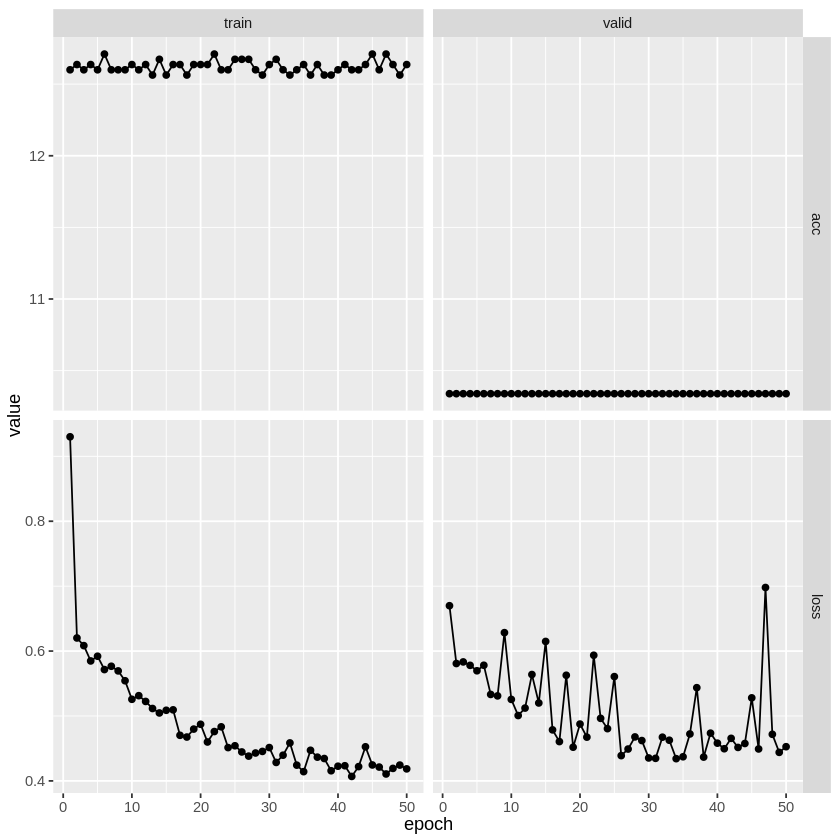

In [26]:
plot(fit_nn)

In [27]:
nn_test <- predict(
    fit_nn, 
    model.matrix(y ~ . - 1, data = df_test)
)
# nn_test
nn_preds <- ifelse(nn_test > 0.5, 1, 0)

table(nn_preds, df_test$y)
mean(nn_preds == df_test$y)

        
nn_preds   0   1
       0 103  21
       1  14  39

[1] 0.8022599

In [28]:
table(glm_preds, df_test$y)
mean(glm_preds == df_test$y)

         
glm_preds   0   1
        0 103  24
        1  14  36

[1] 0.7853107

<br><br><br><br>

---

### DataLoaders

* Dataloaders are a key component in the machine learning pipeline.

* They handle loading and preprocessing data in a way that is efficient for training and evaluating models.

* Dataloaders make it easy to work with large datasets by loading the data in smaller chunks (called **batches**) and applying transformations _on-the-fly_.


##### Why use Dataloaders?

> * **Efficient memory management:** loading data in smaller chunks reduces memory usage.
>
> * **Parallelism:**  supports asynchronous data loading for faster processing.
>
> * **Preprocessing:**  apply data transformations on-the-fly during training and evaluation.
>
> * **Flexibility:**  easily switch between different datasets or preprocessing steps.
>
> * **Standardization:**  consistent data format across various machine learning projects.
>

In [85]:
# ?dataloader

In [29]:
transform <- function(x) x %>% 
    torch_tensor() %>% 
    torch_flatten() %>% 
    torch_div(255)

In [30]:
dir <- "./mnist"

train_ds <- mnist_dataset(
  dir,
  download = TRUE,
  transform = transform
)

test_ds <- mnist_dataset(
  dir,
  download = TRUE,
  train = FALSE,
  transform = transform
)

In [31]:
typeof(train_ds)
length(train_ds)
train_ds$data[42000, ,]

[1] "environment"

[1] 60000

0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,42,218,134,186,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,27,221,253,252,221,16,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,16,190,253,252,252,108,0,0,0
0,0,0,0,0,0,0,0,1,109,⋯,0,0,0,109,252,236,62,0,0,0
0,0,0,0,0,0,0,0,125,252,⋯,0,0,0,109,252,215,42,0,0,0
0,0,0,0,0,0,0,0,62,189,⋯,0,0,21,212,252,241,221,0,0,0


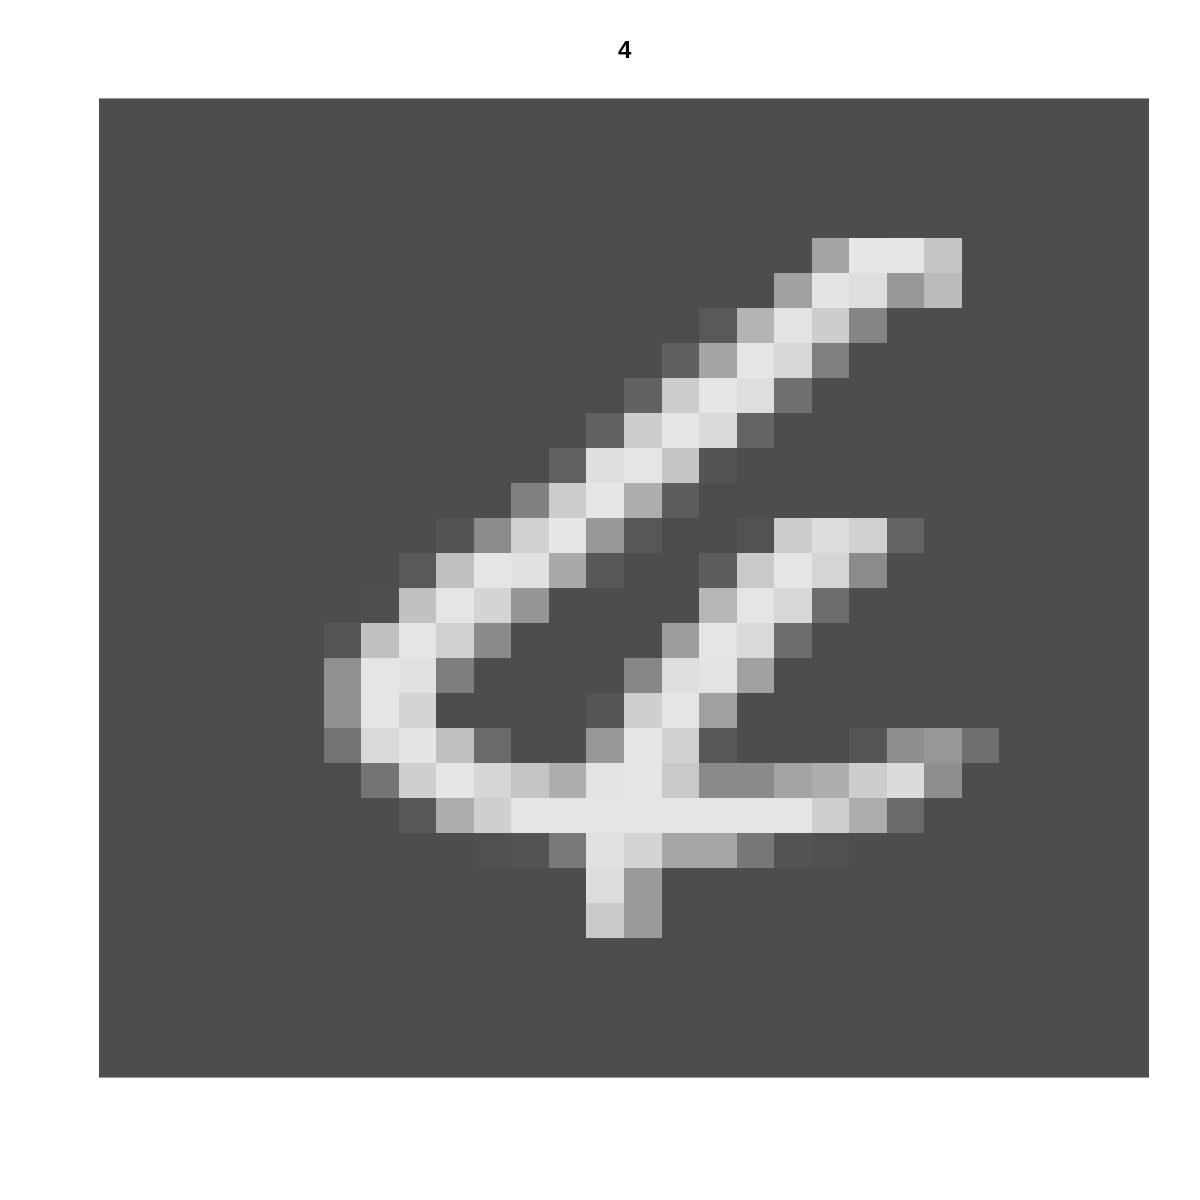

In [63]:
options(repr.plot.width=10, repr.plot.height=10)

i <- sample(1:length(train_ds), 1)
x <- train_ds$data[i, ,] %>% t

image(x[1:28, 28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000), main = train_ds$targets[i]-1 )

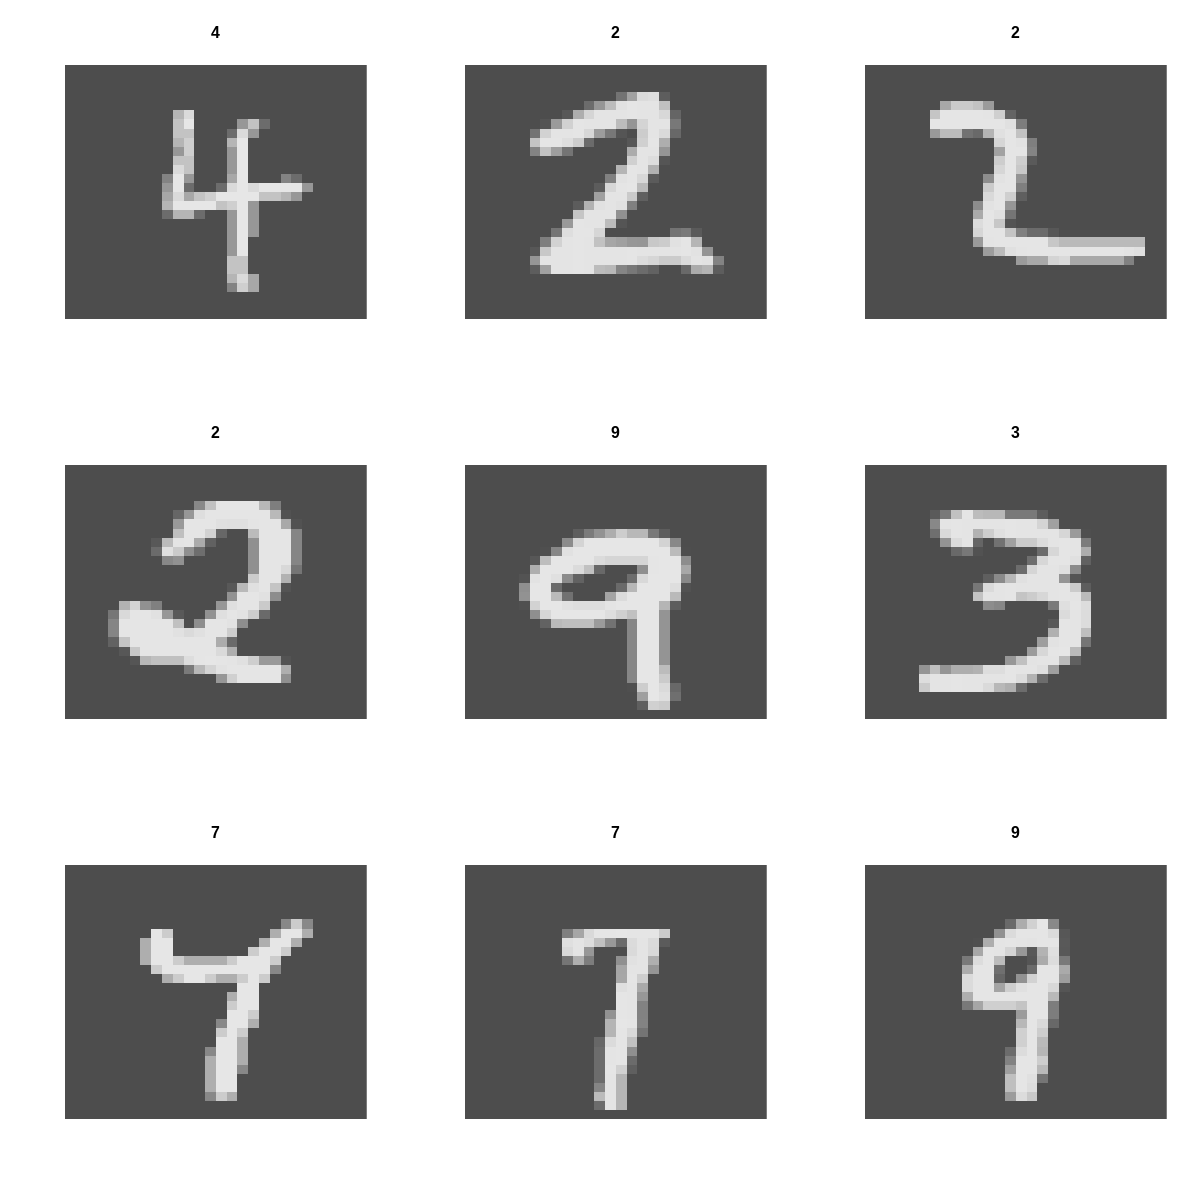

In [64]:
options(repr.plot.width = 10, repr.plot.height = 10)
par(mfrow=c(3,3))

for(iter in 1:9){
    i <- sample(1:length(train_ds), 1)
    x <- train_ds$data[i, ,] %>% t
    image(x[1:28, 28:1], useRaster = TRUE, axes = FALSE, col = gray.colors(1000), main = train_ds$targets[i]-1)
}

<br><br><br><br>
<br><br><br><br>


---

# Image Classification

In [73]:
train_dl <- dataloader(train_ds, batch_size = 2000, shuffle = TRUE)
test_dl <- dataloader(test_ds, batch_size = 2000)

In [74]:
NNet_10 <- nn_module(
  initialize = function(p, q1, q2, q3, o) {
    self$hidden1 <- nn_linear(p, q1)
    self$hidden2 <- nn_linear(q1, q2)
    self$hidden3 <- nn_linear(q2, q3)
    self$OUTPUT <- nn_linear(q3, o)
    self$activation <- nn_relu()
  },
  forward = function(x) {
    x %>%
      self$hidden1() %>%
      self$activation() %>%
      self$hidden2() %>%
      self$activation() %>%
      self$hidden3() %>%
      self$activation() %>%
      self$OUTPUT()
  }
)

In [75]:
fit_nn <- NNet_10 %>%
    #
    # Setup the model
    #
    setup(
        loss = nn_cross_entropy_loss(),
        optimizer = optim_adam,
        metrics = list(
            luz_metric_accuracy()
        )
    ) %>%
    #
    # Set the hyperparameters
    #
    set_hparams(p=28*28, q1=256, q2=128, q3=64, o=10) %>% 
    #
    # Fit the model
    #
    fit(
        #
        # Training Data
        #
        epochs = 10,
        data = train_dl,
        # valid_data = test_dl,
        verbose=TRUE
    )

Epoch 1/10
Train metrics: Loss: 1.474 - Acc: 0.649
Epoch 2/10
Train metrics: Loss: 0.4199 - Acc: 0.8754
Epoch 3/10


In [ ]:
NN10_preds <- fit_nn %>% 
  predict(test_ds) %>% 
  torch_argmax(dim = 2) %>%
  as_array()

NN10_preds